# This is a Tensorflow implementation of Cifar10 data classifier

## Model contains three Convolutional layer and two fully connected layers

Convo_1 : Kernel - 5*5, 32 Filters, Strides = 1 , activation = relu

Max_Pool_1 : Pool Size - [2,2], Strides = 2

Convo_2 : Kernel - 5*5, 64 Filters, Strides = 1  , activation = relu

Max_Pool_2 : Pool Size - [2,2], Strides = 2

Convo_2 : Kernel - 5*5, 128 Filters, Strides = 1  , activation = relu 

Max_Pool_3 : Pool Size - [2,2], Strides = 2

Fully_Connected_1  = Nodes - 1024  , activation = relu

Fully_Connected_2  = Nodes - 1024  , activation = relu

Output Layer = Nodes - 10 , activation = relu



In [1]:
# import necessary packages 
import os
# Load the CIFAR10 dataset
from keras.datasets import cifar10
import math
import numpy as np
import tensorflow as tf
import sys
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# To avoid warning messages change log parameter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Dataset creation 
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xTrain = xTrain.astype(np.float)
yTrain = np.squeeze(yTrain)
yTest = np.squeeze(yTest)
xTest = xTest.astype(np.float)

170500096/170498071 [==============================] - 30s 0us/step


In [0]:
# Normalize dataset to have quick training and better results 
# Normalize the data by subtract the mean image
meanImage = np.mean(xTrain, axis=0)
xTrain -= meanImage
xTest -= meanImage

In [0]:
# Define placeholder for tensorflow graph 
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
keep_prob = tf.placeholder("float")

In [0]:
# Method to plot filter result when you are dealing
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
    plt.savefig('CONV_rslt.png')

In [0]:
# Train model 
def train(xT, yT, xTe, yTe):
    # Model 
    # layer : 2d convolution with relu as activation function
    conv1_layer = tf.layers.conv2d(inputs=x, filters=32, padding='same', kernel_size=5, strides=1,
                                activation=tf.nn.relu)

    # layer : max pooling
    max_pooling_layer_1 = tf.layers.max_pooling2d(inputs=conv1_layer, pool_size=[2, 2], strides=2)

    # layer : 2d convolution with activation function as relu
    conv2_layer = tf.layers.conv2d(inputs=max_pooling_layer_1, filters=64, padding='same', kernel_size=5, strides=1,
                                activation=tf.nn.relu)

    # layer : max pooling
    max_pooling_layer_2 = tf.layers.max_pooling2d(inputs=conv2_layer, pool_size=[2, 2], strides=2)

    # layer : 2d convolution with activation function as relu
    conv3_layer = tf.layers.conv2d(inputs=max_pooling_layer_2, filters=128, padding='same', kernel_size=5, strides=1,
                                activation=tf.nn.relu)

    # layer : max pooling
    max_pooling_layer_3 = tf.layers.max_pooling2d(inputs=conv3_layer, pool_size=[2, 2], strides=2)

    # flatten to provide as input to fully connected layer
    reshape_vector = tf.reshape(max_pooling_layer_3, [-1, 2048])
    fully_connected_layer_1 = tf.layers.dense(inputs=reshape_vector, units=1024, activation=tf.nn.relu)

    batch_normalization = tf.layers.batch_normalization(inputs=fully_connected_layer_1, training=True)
    fully_connected_layer_2 = tf.layers.dense(inputs=batch_normalization, units=1024, activation=tf.nn.relu)

    # fully connected layer
    y_ = tf.layers.dense(inputs=fully_connected_layer_2, units=10, activation=None)

    # Define Loss
    totalLoss = tf.losses.hinge_loss(tf.one_hot(y, 10), logits=y_)
    meanLoss = tf.reduce_mean(totalLoss)

    # Define Optimizer
    optimizer = tf.train.AdamOptimizer(9e-4)
    trainStep = optimizer.minimize(meanLoss)

    # Define correct Prediction and accuracy
    correctPrediction = tf.equal(tf.argmax(y_, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))
    
    # Train Model

    print("Traning Model")
    batchSize = 128
    epochs = 15
    trainIndex = np.arange(xTrain.shape[0])
    np.random.shuffle(trainIndex)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("Loop\tTrain Loss\tTrain Accuracy %\tTest Loss\tTest Accuracy %")
        # Saver method to save model
        save_model = tf.train.Saver()
        # it will save model to local directory
        model_path = 'model/model.ckpt'
        for e in range(epochs):
            # Mini-batch
            losses = []
            accs = []
            # For each batch in training data
            for i in range(int(math.ceil(xTrain.shape[0] / batchSize))):
                # Get the batch data for training
                startIndex = (i * batchSize) % xTrain.shape[0]
                idX = trainIndex[startIndex:startIndex + batchSize]
                currentBatchSize = yTrain[idX].shape[0]
                # Train
                loss, acc, _ = sess.run([meanLoss, accuracy, trainStep], feed_dict={x: xT[idX, :], y: yT[idX]})
                # Collect all mini-batch loss and accuracy
                losses.append(loss * currentBatchSize)
                accs.append(acc * currentBatchSize)
            totalAcc = np.sum(accs) / float(xTrain.shape[0])
            totalLoss = np.sum(losses) / xTrain.shape[0]
            loss, acc = sess.run([meanLoss, accuracy], feed_dict={x: xTe, y: yTe})
            print("{0}\t{1:0.4f}\t\t{2:0.4f}\t\t\t{3:0.4f}\t\t{4:0.4f}".format(e, totalLoss, totalAcc, loss, acc))
            if(acc > 0.75): break
        save_path = save_model.save(sess, model_path)
        print("Model is saved at %s" % save_path)
        sess.close()


In [0]:
# Test Model
def test(file):
    #Model
    # layer : 2d convolution with relu as activation function
    conv1_layer = tf.layers.conv2d(inputs=x, filters=32, padding='same', kernel_size=5, strides=1,
                                activation=tf.nn.relu)

    # layer : max pooling
    max_pooling_layer_1 = tf.layers.max_pooling2d(inputs=conv1_layer, pool_size=[2, 2], strides=2)

    # layer : 2d convolution with activation function as relu
    conv2_layer = tf.layers.conv2d(inputs=max_pooling_layer_1, filters=64, padding='same', kernel_size=5, strides=1,
                                activation=tf.nn.relu)

    # layer : max pooling
    max_pooling_layer_2 = tf.layers.max_pooling2d(inputs=conv2_layer, pool_size=[2, 2], strides=2)

    # layer : 2d convolution with activation function as relu
    conv3_layer = tf.layers.conv2d(inputs=max_pooling_layer_2, filters=128, padding='same', kernel_size=5, strides=1,
                                activation=tf.nn.relu)

    # layer : max pooling
    max_pooling_layer_3 = tf.layers.max_pooling2d(inputs=conv3_layer, pool_size=[2, 2], strides=2)

    # flatten to provide as input to fully connected layer
    reshape_vector = tf.reshape(max_pooling_layer_3, [-1, 2048])
    fully_connected_layer_1 = tf.layers.dense(inputs=reshape_vector, units=1024, activation=tf.nn.relu)

    batch_normalization = tf.layers.batch_normalization(inputs=fully_connected_layer_1, training=False)
    fully_connected_layer_2 = tf.layers.dense(inputs=batch_normalization, units=1024, activation=tf.nn.relu)

    # fully connected layer
    y_ = tf.layers.dense(inputs=fully_connected_layer_2, units=10, activation=None)

    # Define Loss
    totalLoss = tf.losses.hinge_loss(tf.one_hot(y, 10), logits=y_)
    meanLoss = tf.reduce_mean(totalLoss)

    # Define Optimizer
    optimizer = tf.train.AdamOptimizer(9e-4)
    trainStep = optimizer.minimize(meanLoss)

    # Define correct Prediction and accuracy
    correctPrediction = tf.equal(tf.argmax(y_, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))
    
    # Test your image with trained dataset
    print("Testing Model")
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    image = cv2.imread(file)
    image = cv2.resize(image,(32,32))
    image = np.reshape(image, (1, 32, 32, 3))
    image = image.astype(np.float32)
    model_path = 'model/model.ckpt'
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    new_saver = tf.train.import_meta_graph('model/model.ckpt.meta')
    new_saver.restore(sess,model_path)
    test_loss = sess.run(y_,feed_dict={x:image})
    print(classes[np.argmax(test_loss)])
    units = sess.run(conv1_layer,feed_dict={x:image,keep_prob:1.0})
    plotNNFilter(units)
    sess.close()


In [33]:
# Upload Test Image 
# If possible upload image as test.png
from google.colab import files
uploaded = files.upload()

Saving test.png to test.png


Start execution
Traning Model
Loop	Train Loss	Train Accuracy %	Test Loss	Test Accuracy %
0	0.2231		0.4621			0.1731		0.5966
1	0.1565		0.6393			0.1445		0.6695
2	0.1279		0.7101			0.1337		0.6943
3	0.1097		0.7554			0.1289		0.7097
4	0.0989		0.7798			0.1182		0.7328
5	0.0853		0.8153			0.1189		0.7354
6	0.1172		0.7280			0.1217		0.7255
7	0.0866		0.8087			0.1156		0.7462
8	0.0725		0.8423			0.1205		0.7481
9	0.0686		0.8514			0.1488		0.6656
10	0.0702		0.8492			0.1194		0.7554
Model is saved at model/model.ckpt
Testing Model
INFO:tensorflow:Restoring parameters from model/model.ckpt
airplane
end of execution


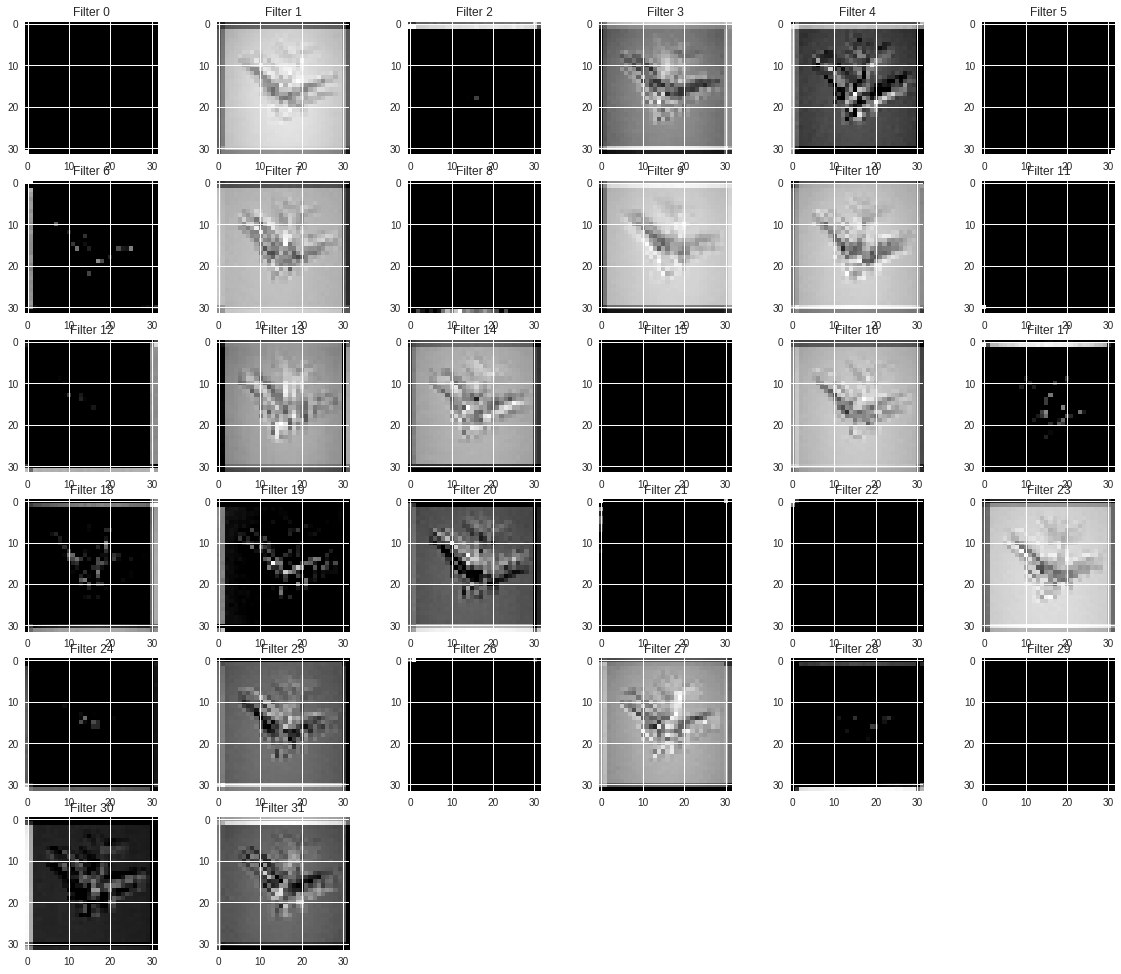

In [34]:
# Calling methods for training and testing 
print("Start execution")
train(xTrain, yTrain, xTest, yTest)
#replace the file name you uploaded for testing here, 
test("test.png")
print("end of execution")